## Random Forest

Author: Elisa Warner
Created: 4/16/2019

Purpose: Check results of SVM against stock data

Change Record:
6/11/2019 Made Time-Cross Validation be non-overlapping

## Confusion Table Function

In [1]:
###########################
## Create confusion table
###########################

import matplotlib
import matplotlib.pyplot as plt

def prediction_box(predictions, ground_truth):
    ## results
    result = {'tp':0, 'fp':0, 'tn':0, 'fn':0}

    for i in range(len(predictions)):
        #print(pred_test[i], y[i])
        if predictions[i] == ground_truth[i] and ground_truth[i] == 1:
            result['tp'] = result.get('tp', 0) + 1
        elif predictions[i] == ground_truth[i] and ground_truth[i] == 0:
            result['tn'] = result.get('tn', 0) + 1
        elif predictions[i] != ground_truth[i] and ground_truth[i] == 1:
            result['fn'] = result.get('fn', 0) + 1
        else:
            result['fp'] = result.get('fp', 0) + 1

    m = np.array([[result['tp'], result['fn']],[result['fp'],result['fn']]])
    fig, ax = plt.subplots()
    im = ax.imshow(m, cmap='Pastel1')
    
    for i in range(m.shape[0]):
        for j in range(m.shape[1]):
            plt.text(j, i, "{:.2f}".format(m[i,j]), ha="center", va="center")
            plt.title('Predictions for Test Set')
            ax.set_xticks([0, 1])
            ax.set_yticks([0, 1])
            ax.set_xticklabels([1, 0])
            ax.set_yticklabels([1, 0])
            plt.ylabel('Ground Truth')
            plt.xlabel('Prediction')

### Remove Missing

In [2]:
def remove_missing(df):
    for col in list(df):
        colvals = df[col].values
        new_colvals = []
        for i in range(len(colvals)):
            if colvals[i] == '.':
                print('Missing found')
                new_colvals.append(colvals[i-1])
            elif pd.isnull(colvals[i]):
                print('nan found')
                new_colvals.append(colvals[i-1])
            else:
                new_colvals.append(colvals[i])
        df[col] = new_colvals
    
    return df

In [3]:
def remove_missing_horz(df):
    new_df = pd.DataFrame()
    for i in range(df.shape[0]):
        row = list(df.iloc[i].values)

        if '.' in row:
            idx_list = [i for i in range(len(row)) if row[i] == ('.')]
            for idx in idx_list:
                row[idx] = row[idx - 1]

        idx_list = [i for i in range(len(row)) if pd.isnull(row[i]) == True]
        for idx in idx_list:
            row[idx] = row[idx - 1]
            
        new_df = new_df.append(pd.DataFrame(row).T, ignore_index = True)
    
    return new_df

## 1. Load Data

In [4]:
#!pip3 install -U scikit-learn scipy matplotlib

In [5]:
import pandas as pd
from sklearn import svm
import numpy as np

In [32]:
file1 = "./Combined_Sets_from_Revised.csv" #"Draft_Google_Shorter.csv" #Removed Missing

train_pd = pd.read_csv(file1)
train_pd.shape

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(7120, 491)

In [33]:
train_pd = train_pd[5903:]

train = np.array(train_pd)
train.shape

(1217, 491)

In [34]:
train = train[:,1:] # drop date
train

array([[1, 1166.569946, 2.613, ..., 4.0, 4.0, 20.0],
       [1, 1165.790039, 2.635, ..., 4.0, 4.0, 20.0],
       [1, 1161.660034, 2.64, ..., 4.0, 4.0, 20.0],
       ...,
       [4, 1697.430054, 2.512, ..., 8.0, 8.0, 46.0],
       [4, 1706.280029, 2.501, ..., 8.0, 8.0, 46.0],
       [4, 1707.6700440000004, 2.519, ..., 6.0, 4.0, 55.0]], dtype=object)

In [35]:
train_pd

,Dates,Label_m30,main0,main1,main2,main3,main4,main5,main6,main7,...,google_hits262,google_hits263,google_hits264,google_hits265,google_hits266,google_hits267,google_hits268,google_hits269,google_hits270,google_hits271
5903,7/7/14,1,1166.569946,2.613,0.158945,0.684881,0.193924,1165.790039,2.635,0.158510,...,14.0,19.0,10.0,11.0,19.0,22.0,0.0,4.0,4.0,20.0
5904,7/8/14,1,1165.790039,2.635,0.158510,0.684518,0.193070,1161.660034,2.640,0.157116,...,14.0,19.0,10.0,11.0,19.0,22.0,0.0,4.0,4.0,20.0
5905,7/9/14,1,1161.660034,2.640,0.157116,0.684144,0.191065,1153.599976,2.586,0.154885,...,14.0,19.0,10.0,11.0,19.0,22.0,0.0,4.0,4.0,20.0
5906,7/10/14,1,1153.599976,2.586,0.154885,0.681075,0.189443,1157.239990,2.604,0.151331,...,14.0,19.0,10.0,11.0,19.0,22.0,0.0,4.0,4.0,20.0
5907,7/11/14,1,1157.239990,2.604,0.151331,0.678147,0.184754,1158.410034,2.597,0.156583,...,14.0,19.0,10.0,11.0,19.0,22.0,0.0,4.0,4.0,20.0
5908,7/14/14,1,1158.410034,2.597,0.156583,0.669512,0.195087,1162.000000,2.655,0.157412,...,6.0,11.0,39.0,9.0,23.0,15.0,3.0,4.0,6.0,14.0
5909,7/15/14,1,1162.000000,2.655,0.157412,0.669142,0.195567,1170.449951,2.613,0.159634,...,6.0,11.0,39.0,9.0,23.0,15.0,3.0,4.0,6.0,14.0
5910,7/16/14,1,1170.449951,2.613,0.159634,0.668798,0.199618,1171.939941,2.622,0.158125,...,6.0,11.0,39.0,9.0,23.0,15.0,3.0,4.0,6.0,14.0
5911,7/17/14,1,1171.939941,2.622,0.158125,0.666257,0.197980,1174.260010,2.624,0.153846,...,6.0,11.0,39.0,9.0,23.0,15.0,3.0,4.0,6.0,14.0
5912,7/18/14,1,1174.260010,2.624,0.153846,0.663897,0.192207,1173.880005,2.623,0.160635,...,6.0,11.0,39.0,9.0,23.0,15.0,3.0,4.0,6.0,14.0


## 2. Time-Series Cross validation

In [36]:
def time_cross(array, time_shift = 0, size_train_set = 365, size_val_set = 100, set_shift = 0):
    np.random.seed(100)
    label_idx = 0

    if time_shift == 0:
        time_shift = size_train_set + size_val_set + set_shift
        
    train_size = train.shape
    j = 0
    group = 1
    end = train_size[0]
    trainDataPartition = [] # list
    valDataPartition = []

    #print(size_train_set, size_val_set, train_size[0])
    while j + (size_train_set + size_val_set + set_shift) < train_size[0]:
        trainset = []
        valset = []

        trainset = train[j:j+size_train_set, :] # array
        valset = train[j+size_train_set+1+set_shift:j+size_train_set+size_val_set+set_shift, :]

        trainDataPartition.append(trainset)
        valDataPartition.append(valset)
    
        group = group+1;
        j = j + time_shift


    # make last set -- decide if you want to throw out or adjust this set
    trainset = train[j:j+size_train_set, :]
    valset = train[j+size_train_set+1+set_shift:end, :]
    
    trainDataPartition.append(trainset)
    valDataPartition.append(valset)

    
    ### Optional: stratify
    revised_trainDataPartition = []
    for i in range(len(trainDataPartition)):
        trainset = trainDataPartition[i]
        #print(trainset)
        records = trainset[:,0] # record of labels
        #print(sum(records == 1), sum(records == 0))
        if sum(records == 1) == 0 or sum(records == 0) == 0:
            revised_trainDataPartition.append(np.nan)
        elif sum(records == 1) > sum(records == 0):
            while sum(records == 1) >= 1.3 * sum(records == 0):
                r = round(np.random.rand() * (trainset.shape[0]-1))
                #print(r)
                if records[r] == 1:
                    trainset = np.delete(trainset, r, 0)
                    records = np.delete(records, r)

            revised_trainDataPartition.append(trainset)
        else:
            while sum(records == 1) <= 1.3 * sum(records == 0):
                r = round(np.random.rand() * (trainset.shape[0]-1))
                if records[r] == 0:
                    trainset = np.delete(trainset, r, 0)
                    records = np.delete(records, r)

            revised_trainDataPartition.append(trainset)
        #print(sum(records == 1), sum(records == 0))

    group = len(revised_trainDataPartition)
    print(group)
    
    return revised_trainDataPartition, valDataPartition, group

In [37]:
trainDataPartition, valDataPartition, group = time_cross(train, 0, 260, 100, 30)
print(len(trainDataPartition), len(valDataPartition))

4
4 4


In [44]:
t = pd.DataFrame(valDataPartition[0])
t.head(n=10)

,0,1,2,3,4,5,6,7,8,9,...,480,481,482,483,484,485,486,487,488,489
0,0,1249.02,2.211,0.148873,0.340656,0.372116,1252.81,2.268,0.14969,0.340436,...,30,23,15,8,22,20,3,2,2,13
1,0,1252.81,2.268,0.14969,0.340436,0.373081,1242.11,2.234,0.145837,0.340384,...,30,23,15,8,22,20,3,2,2,13
2,0,1242.11,2.234,0.145837,0.340384,0.362818,1238.28,2.175,0.142869,0.340344,...,30,23,15,8,22,20,3,2,2,13
3,0,1238.28,2.175,0.142869,0.340344,0.355873,1254.21,2.238,0.146492,0.340711,...,30,23,15,8,22,20,3,2,2,13
4,0,1254.21,2.238,0.146492,0.340711,0.364272,1242.37,2.137,0.143138,0.340486,...,30,23,15,8,22,20,3,2,2,13
5,1,1242.37,2.137,0.143138,0.340486,0.357629,1243.01,2.13,0.14312,0.340261,...,15,10,25,16,18,18,0,2,2,20
6,1,1243.01,2.13,0.14312,0.340261,0.358019,1241.36,2.189,0.143166,0.340243,...,15,10,25,16,18,18,0,2,2,20
7,1,1241.36,2.189,0.143166,0.340243,0.356439,1246.56,2.196,0.144719,0.340215,...,15,10,25,16,18,18,0,2,2,20
8,1,1246.56,2.196,0.144719,0.340215,0.360829,1254.14,2.15,0.143025,0.340635,...,15,10,25,16,18,18,0,2,2,20
9,1,1254.14,2.15,0.143025,0.340635,0.356761,1250.01,2.196,0.141733,0.340416,...,15,22,14,11,22,31,0,4,2,31


## 3. Random Forest Implementation
No normalization necessary for Random Forest

In [45]:
##############################################################################
### Try Random Forest Classifier

import sklearn.model_selection
import sklearn.metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [48]:
def rf(train_list, val_list, group):
    splits = group
    score = []

    #kf = sklearn.model_selection.KFold(n_splits=splits, random_state = 10, shuffle = True)
    #kf.get_n_splits(features)

    data_size = trainDataPartition[0].shape

    for idx in range(len(trainDataPartition)-1):
            # print("TRAIN:", train_index, "TEST:", test_index)
            #try:
            X_train, y_train = trainDataPartition[idx][:,1:data_size[1]+1], trainDataPartition[idx][:,0]
            y_train = y_train.astype('int')
            #print(X_train)
            X_test, y_test = valDataPartition[idx][:,1:data_size[1]+1], valDataPartition[idx][:,0]
            y_test = y_test.astype('int')
            print('train:', sum(y_train), len(y_train))
            print('test:', sum(y_test), len(y_test))

            # Fit the RF model
            clf = RandomForestClassifier(n_estimators=50, max_depth=1500, random_state=0)
            clf.fit(X_train, y_train)
            #except:
            #    continue # nan
                
            # print predicitions
            pred = clf.predict(X_test)
            #print(pred)

            # add up AUROCs
            
            try:
                temp_score = sklearn.metrics.roc_auc_score(y_test, pred)
                #temp_score = sklearn.metrics.accuracy_score(y_test,pred)
                #score = score + sklearn.metrics.accuracy_score(y_test, pred)
                #temp_score = sum([1 for i in range(len(pred)) if pred[i] == y_test[i]]) / len(pred)
                score.append(temp_score)
                print(temp_score)
            except:
                pass


    # calculate average
    score = np.mean(score)
    print("Averaged Score is: %0.4f" % score, splits)


    # print(clf.feature_importances_)
    
    return score

In [49]:
print('groups', group)
rf(valDataPartition, trainDataPartition, group)

groups 4
train: 139 246
test: 43 99


ValueError: could not convert string to float: '.'

Hyperparameter Test

In [17]:
### Test
# time_shift, size_train_set, size_val_set

time_shift = [0] # smaller time shift is better, smaller training set, smaller val set 0, 50, 100, 126, 252, 504
# 504 252 50 0.61268998
size_train_set = [100, 252, 410]
size_val_set = [50, 100, 260] # predict a month ahead (shift labels)

score_matrix = np.zeros((len(time_shift), len(size_train_set), len(size_val_set)))

for i in range(len(time_shift)):
    for j in range(len(size_train_set)):
        for k in range(len(size_val_set)):
            time_shift = size_val_set[k]
            print(time_shift, size_train_set[j], size_val_set[k])
            trainDataPartition, valDataPartition, group = time_cross(train, time_shift, size_train_set[j], size_val_set[k], 30)

            #time_shift[i]
            score_matrix[i][j][k] = rf(valDataPartition, trainDataPartition, group)

print(np.argmax(score_matrix, axis = 1))
print(score_matrix)
#0.61268998 Didn't work so well with Label 2
# Perfomed well with predicting next day with Google Trends 0.8975, best was 0.96

50 100 50
38
train: 29 51
test: 26 49
0.5192307692307693
train: 41 72
test: 18 49
0.5
train: 42 74
test: 4 49
0.7666666666666666
train: 27 47
test: 32 49
0.5
train: 30 53
test: 17 49
0.5
train: 38 67
test: 49 49
train: 49 87
test: 39 49
0.5
train: 32 57
test: 25 49
0.4275
train: 18 32
test: 31 49
0.46236559139784955
train: 44 78
test: 25 49
0.5
train: 42 74
test: 9 49
0.5
train: 55 100
test: 27 49
0.5
train: 40 70
test: 27 49
0.5
train: 32 56
test: 39 49
0.5897435897435898
train: 41 73
test: 42 49
0.5
train: 23 41
test: 6 49
0.5678294573643411
train: 46 82
test: 29 49
0.375
train: 44 77
test: 41 49
0.9268292682926829
train: 45 79
test: 22 49
0.6456228956228957
train: 42 75
test: 44 49
0.5
train: 35 62
test: 0 49
train: 56 100
test: 14 49
0.5
train: 33 58
test: 12 49
0.5765765765765765
train: 20 35
test: 14 49
0.5
train: 18 31
test: 23 49
0.5
train: 38 67
test: 29 49
0.5077586206896552
train: 38 67
test: 32 49
0.5
train: 47 83
test: 25 49
0.4791666666666667
train: 33 59
test: 30 49
0.57

In [18]:
t = np.max(score_matrix, axis = 1)
#print(np.argmax(t, axis = 1))
t

array([[0.54583007, 0.52638612, 0.5326131 ]])

# Look for Feature Importances

In [19]:
trainDataPartition, valDataPartition, group = time_cross(train, 0, 252, 50, 30) #10 252 100 Draft_Google_shorter 0.8795

7


In [20]:
splits = group
score_list = []
indices = []
pred_labels = []

data_size = trainDataPartition[0].shape

for idx in range(len(trainDataPartition)-1):
    try:
        # print("TRAIN:", train_index, "TEST:", test_index)
        X_train, y_train = trainDataPartition[idx][:,1:data_size[1]+1], trainDataPartition[idx][:,0]
        y_train = y_train.astype('int')
        #print(X_train)
        X_test, y_test = valDataPartition[idx][:,1:data_size[1]+1], valDataPartition[idx][:,0]
        y_test = y_test.astype('int')
        print('train:', sum(y_train), len(y_train))
        print('test:', sum(y_test), len(y_test))
    
        # Fit the RF model
        clf = RandomForestClassifier(n_estimators=100, max_depth=1500, random_state=0) # previously 7
        clf.fit(X_train, y_train)

        # print predicitions
        pred = clf.predict(X_test)
        pred_labels.append(pred)
        #print(pred)
    except:
        continue #np.nan
        
    # add up AUROCs
            
    try:
        temp_score = sklearn.metrics.roc_auc_score(y_test, pred)
        score_list.append(temp_score)
        indices.append(idx)
        print(temp_score)
    except:
        pass


# calculate average
score = np.mean(score_list)
print("Averaged Score is: %0.4f" % score, splits)

train: 91 160
test: 31 49
0.5833333333333333
train: 113 200
test: 23 49
0.6454849498327758
train: 141 252
test: 24 49
0.4841666666666667
train: 122 215
test: 14 49
0.5
train: 140 248
test: 28 49
0.5
train: 105 186
test: 6 49
0.5542635658914729
Averaged Score is: 0.5445 7


Plot the accuracy through time

Standard Deviation: 0.05686521477316641


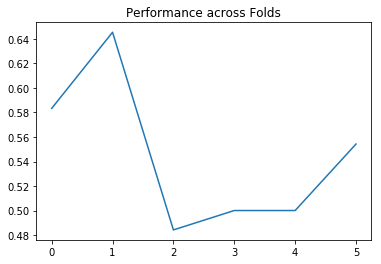

In [24]:
import matplotlib.pyplot as plt
print("Standard Deviation:", np.std(score_list))
plt.figure()
plt.plot(indices, score_list)
plt.title('Performance across Folds')
plt.show()

Which features are important during the time when the datasets are accurate?

In [31]:
indices = [x for x in range(len(score_list)) if score_list[x] > 0.75]
importance = np.array([])
count = 0

for idx in range(1220, 1235): # for several months of 2012, May - end of November, 1180, 1281
    # run random forest
    try:

        X_train, y_train = trainDataPartition[idx][:,1:data_size[1]+1], trainDataPartition[idx][:,0]
        y_train = y_train.astype('int')

        X_test, y_test = valDataPartition[idx][:,1:data_size[1]+1], valDataPartition[idx][:,0]
        y_test = y_test.astype('int')
    
        # Fit the RF model
        clf = RandomForestClassifier(n_estimators=20, max_depth=1500, random_state=0) # previously 7
        clf.fit(X_train, y_train)

        # print predicitions
        pred = clf.predict(X_test)
    
        if not importance.any():
            print('hi')
            importance = clf.feature_importances_
        else:
            importance = importance + clf.feature_importances_

        count+=1
    except:
        continue #np.nan

    try:
        temp_score = sklearn.metrics.roc_auc_score(y_test, pred)
        score_list.append(temp_score)
        indices.append(idx)
        print(temp_score)
    except:
        pass

ValueError: shape mismatch: objects cannot be broadcast to a single shape

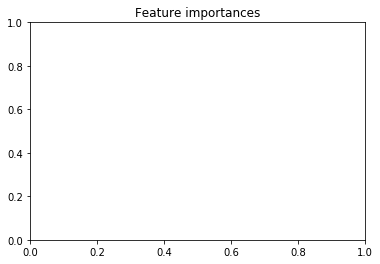

In [30]:
importance = importance / count
feature_indices = np.argsort(importance)[::-1]

# Plot the feature importances of the forest (ERROR HIDDEN, TOO BIG)
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importance[feature_indices],
       color="r", align="center") # X_train.shape[1]
plt.xticks(range(X_train.shape[1]), feature_indices) #X_train.shape[1]
plt.xlim([-1, 100]) #X_train.shape[1]]) 
plt.show()

In [ ]:
name = 'Combined_Sets_from_Revised_3.csv'
df = pd.read_csv(name)
df = df.drop(['Date'], axis = 1)

# Show all the list of features and their respective importances

#listoffeatures = list(train_pd)[1:]
listoffeatures = list(df)
shortlist = []

print('Top Features listed by Importance')

for i in range(len(feature_indices)-1):
    idx = feature_indices[i]
    print(listoffeatures[idx], importance[idx])
    if i <= 25:
        shortlist.append(listoffeatures[idx])
shortlist

# Feature Importance

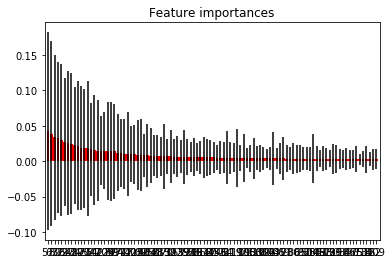

In [32]:
# Create a graph of fetaure importances

import matplotlib.pyplot as plt

importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest (ERROR HIDDEN, TOO BIG)
plt.figure()
plt.title("Feature importances")
plt.bar(range(100), importances[indices[0:100]],
       color="r", yerr=std[indices[0:100]], align="center") # X_train.shape[1]
plt.xticks(range(100), indices[0:100]) #X_train.shape[1]
plt.xlim([-1, 100]) #X_train.shape[1]]) 
plt.show()

In [33]:
print(len(clf.feature_importances_))
print(len(list(train_pd)[1:]))

217
218


In [36]:
name = '../Data/Combined_Sets_from_Revised_3.csv'
df = pd.read_csv(name)
df = df.drop(['Date'], axis = 1)

In [37]:
# Show all the list of features and their respective importances

#listoffeatures = list(train_pd)[1:]
listoffeatures = list(df)
shortlist = []

print('Top Features listed by Importance')

for i in range(len(indices)-1):
    idx = indices[i]
    print(listoffeatures[idx], importances[idx])
#    if i <= 50:
#        shortlist.append(listoffeatures[i])

Top Features listed by Importance
main56 0.04246516422174906
main66 0.038890888318713866
main81 0.03352209371117746
main31 0.03316343824589267
main71 0.029538007701172927
main61 0.027638836562973338
main96 0.026174527778898057
main41 0.024717976602409993
main33 0.022179143584261544
main86 0.02192126337972254
google_hits40 0.018536965272188975
main26 0.018094151121507362
main51 0.017907962611983155
main53 0.01662669776174378
main46 0.015511696529390826
main6 0.015034778619333933
invest5 0.014968034625538185
google_hits53 0.014830217360014095
main28 0.01446104855036105
main36 0.013716114196511751
main48 0.01369902198463893
main93 0.012202968050008907
main76 0.011880261213021217
main73 0.010328238974565888
main16 0.010052793341765304
main19 0.009764406723616902
invest3 0.009464639641187931
main11 0.00859702479350911
main88 0.008526362192154482
main39 0.008260623177502284
main24 0.008066004010519183
main82 0.007844714248476117
gfp8 0.007815534136366665
main87 0.007041696130779015
google_hi

# SVM

In [45]:
trainDataPartition, valDataPartition, group = time_cross(train, 0, 410, 50) #10 252 100 Draft_Google_shorter 0.8795

5


In [46]:
test = pd.DataFrame(valDataPartition[1])

In [47]:
splits = group
score = []
good_sets = []
gammas = []

data_size = trainDataPartition[0].shape

for idx in range(len(trainDataPartition)-1):
    try:
        # print("TRAIN:", train_index, "TEST:", test_index)
        X_train, y_train = trainDataPartition[idx][:,1:data_size[1]+1], trainDataPartition[idx][:,0]
        y_train = y_train.astype('int')
        #print(X_train)
        X_test, y_test = valDataPartition[idx][:,1:data_size[1]+1], valDataPartition[idx][:,0]
        y_test = y_test.astype('int')
        print('train:', sum(y_train), len(y_train))
        print('test:', sum(y_test), len(y_test))
        #print(1 / (X_train.shape[1] * X_train.var()))
        # Fit the RF model

        #gamma =  (1 / (X_train.shape[1] * X_train.var()))
        clf = sklearn.svm.SVC(C=.7, kernel='rbf', gamma='scale') # previously 7
        clf.fit(X_train, y_train)
    except:
        continue

    # print predicitions
    pred = clf.predict(X_test)
    #print(pred)

    # add up AUROCs
            
    try:
        temp_score = sklearn.metrics.roc_auc_score(y_test, pred)
        score.append(temp_score)
        print(temp_score)
        if temp_score > 0.7:
            good_sets.append(idx)
            gammas.append(1 / (X_train.shape[1] * X_train.var()))
    except:
        pass


# calculate average
score = np.mean(score)
print("Averaged Score is: %0.4f" % score, splits)

train: 173 306
test: 40 49
train: 219 388
test: 12 49
train: 178 314
test: 23 49
train: 205 363
test: 22 49
Averaged Score is: nan 5


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
good_sets

In [ ]:
pred_labels2 = []
for predlist in pred_labels:
    for x in range(len(predlist)):
        pred_labels2.append(predlist[x])
pred_labels2

# Test just one giant set
Why: Because if we can get more than 50%, we can get predictions for everything in the training set. Let's see if we can get some kind of "universal" model

In [614]:
file1 = "Combined_Sets_from_Revised_3_Label1.csv" #"Draft_Google_Shorter.csv" #Removed Missing

train_pd = pd.read_csv(file1)
train_pd.shape

(7120, 219)

In [615]:
train_pd = train_pd[6184:]

train = np.array(train_pd)
train.shape

(936, 219)

In [683]:
valDataPartition[7]

array([[1.0, 786.5599980000001, 2.908, ..., 0.0, 0.0, 26.0],
       [1.0, 789.5, 2.891, ..., 0.0, 0.0, 26.0],
       [1.0, 783.119995, 2.944, ..., 0.0, 0.0, 26.0],
       ...,
       [1.0, 683.849976, 1.9669999999999999, ..., 1.0, 1.0, 36.0],
       [1.0, 705.049988, 1.9580000000000002, ..., 1.0, 1.0, 36.0],
       [1.0, 706.179993, 1.996, ..., 1.0, 1.0, 36.0]], dtype=object)